In [89]:
from astropy.coordinates import SkyCoord, FK4
from astropy.io import ascii, fits
from astropy.io.votable import parse_single_table
from astropy.table import Column
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from astropy.visualization import simple_norm
from astropy.coordinates import ICRS
import regions
import cmasher as cmr


## Produce Source maps of the SMC field 

### Table of Contents

* [GASKAP Source plot](#GASKAP-Source-plot)
* [GASKAP Source plot](#GASKAP-Source-plot)
* [G340 Field Source Plot](#G340-Field-Source-Plot)
* [SMC source noise plot](#SMC-source-noise-plot)
* [Spin temperature distribution plot](#Spin-temperature-distribution-plot)

In [2]:


def recenter(ax, wcs, x, y, radius=None, width=None, height=None):
    '''
    Center the image on a given position and with a given radius.

    Either the radius or width/heigh arguments should be specified.

    Parameters
    ----------

    x, y : float
        Coordinates to center on

    radius : float, optional
        Radius of the region to view. This produces a square plot.

    width : float, optional
        Width of the region to view. This should be given in
        conjunction with the height argument.

    height : float, optional
        Height of the region to view. This should be given in
        conjunction with the width argument.
    '''

    xpix, ypix = wcs.wcs_world2pix(x, y, 0)
    
    pix_scale = proj_plane_pixel_scales(wcs)
    sx, sy = pix_scale[1], pix_scale[0]

    if radius:
        dx_pix = radius / sx
        dy_pix = radius / sy
    elif width and height:
        dx_pix = width / sx * 0.5
        dy_pix = height / sy * 0.5
    else:
        raise Exception("Need to specify either radius= or width= and height= arguments")

    if (xpix + dx_pix < -0.5 or
        xpix - dx_pix > wcs.array_shape[1] - 0.5 or
        ypix + dy_pix < -0.5 or
            ypix - dy_pix > wcs.array_shape[1]):

        raise Exception("Zoom region falls outside the image")

    ax.set_xlim(xpix - dx_pix, xpix + dx_pix)
    ax.set_ylim(ypix - dy_pix, ypix + dy_pix)


def get_field_centre(sources):
    min_ra = np.min(sources['ra'])
    max_ra = np.max(sources['ra'])
    min_dec = np.min(sources['dec'])
    max_dec = np.max(sources['dec'])
    print (min_ra, max_ra, min_dec, max_dec)
    width = max_ra-min_ra
    height = max_dec-min_dec
    centre_ra = min_ra + width/2
    centre_dec = min_dec + height/2
    field_centre = SkyCoord(ra=centre_ra*u.deg, dec=centre_dec*u.deg, frame=FK4)
    print (field_centre)
    return field_centre


def add_sources(ax, sources,detection, best, is_mw):

    for src in sources:
        colour_name = 'seagreen'
        facecolor = 'seagreen'
        #sigma = (1-src['min_opacity'])/src['sd_cont']
    
        marker = '.'
        if src['has_other_abs'] or (is_mw and src['has_mw_abs']):
            marker = 'o'
            facecolor = 'none'
            colour_name = 'orange'

        #elif src['has_mw_abs']:
        #    marker = 's'
        #    facecolor = 'none'
        #    colour_name = 'yellow'
            
        elif src['rating'] <= 'B':
            marker = '+'
            facecolor = 'darkgreen'

        ax.scatter([src['ra']], [src['dec']], transform=ax.get_transform('world'), 
               marker=marker, edgecolor=colour_name, facecolor=facecolor)


def plot_background_map(fig, background, lon_tick_labels='rb', fontsize=12):

    # moment zero map
    mom0 = fits.open(background)

    no_nan_data = np.nan_to_num(mom0[0].data)
    nh_data = no_nan_data * 1.82 * 10**18 /1e3
    vmin=np.percentile(nh_data, 0.25)
    vmax=np.percentile(nh_data, 99.75)

    # Create an ImageNormalize object
    vmid = vmin - (vmax - vmin) / 30.
    asinh_a = (vmid - vmin) / (vmax - vmin)
    norm_kwargs = {'asinh_a': abs(asinh_a)}
    norm = simple_norm(nh_data, 'asinh', min_cut=vmin, max_cut=vmax, clip=False,
                                    **norm_kwargs)

    wcs = WCS(mom0[0].header)
    #hdu = mom0[0]


    #frame = ICRS()
    #from reproject.mosaicking import find_optimal_celestial_wcs
    #wcs, shape = find_optimal_celestial_wcs([hdu], frame=frame)

    #from reproject import reproject_interp
    #data, _ = reproject_interp(hdu, wcs, shape_out=shape)
    #header = wcs.to_header()
    #header['NAXIS1'] = shape[1]
    #header['NAXIS2'] = shape[0]
    #wcs = WCS(header, relax=True)
    
    ax = fig.add_subplot(111, projection=wcs)
    im = ax.imshow(nh_data, cmap='gist_yarg', vmin=vmin, vmax=vmax, alpha=0.6, norm=norm)

    lon = ax.coords[0]
    lat = ax.coords[1]
    #lon.set_ticks(number=12)
    lon.set_ticks_position('rb')
    lon.set_ticklabel_position(lon_tick_labels)
    lon.set_axislabel_position('b')

    #lat.set_ticks(number=12)
    lat.set_ticks_position('tl')
    lat.set_ticklabel_position('l')
    lat.set_axislabel_position('l')

    # Add axes labels
    ax.set_xlabel("Right Ascension (hours)", fontsize=fontsize)
    ax.set_ylabel("Declination (degrees)", fontsize=fontsize)

    ax.grid()
    return ax, wcs


def plot_source_loc_map(spectra_table, figures_folder, is_mw, background='hi_zea_ms_mom0.fits', name='source_loc',
                       field_centre=None):

    print('\nPlotting {} source locations over background of {}.'.format(len(spectra_table), background))

    fig = plt.figure(figsize=(7.2, 5.4))
    ax, wcs = plot_background_map(fig, background)

    if field_centre is None:
        field_centre = get_field_centre(spectra_table)
    try:
        recenter(ax, wcs, field_centre.ra.value, field_centre.dec.value, width=8.25, height=7.25)  # degrees
    except Exception as ex:
        print(ex)
        return

    # Display the moment map image
    #plt.colorbar(im,fraction=0.046, pad=0.04)
    add_sources(ax, spectra_table, 3, 5, is_mw)

    prefix = figures_folder + "/" + name
    print ("  Output", prefix+".png")
    fig.savefig(prefix + ".png", bbox_inches='tight')
    fig.savefig(prefix + ".pdf", bbox_inches='tight')
    return field_centre


### GASKAP Source plot

In [3]:
plt.rc('font', family='serif')


Plotting 229 source locations over background of hi_zea_ms_mom0.fits.
6.586833 24.834905 -74.721395 -70.011737
<SkyCoord (FK4: equinox=B1950.000, obstime=B1950.000): (ra, dec) in deg
    (15.710869, -72.366566)>


/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_718/3829371547.py:87: UserWarning: You passed a edgecolor/edgecolors ('seagreen') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter([src['ra']], [src['dec']], transform=ax.get_transform('world'),


  Output figures/source_loc_gaskap.png


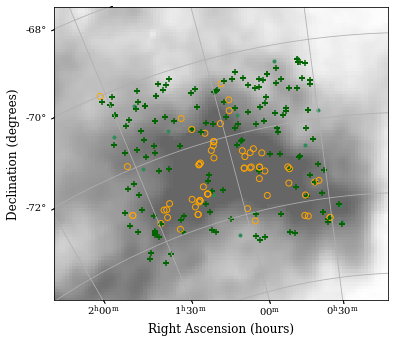

In [4]:
#spectra_table = parse_single_table('sb10944/v3a/askap_spectra.vot').to_table()
spectra_table = parse_single_table('gaskap_smc_spectra.vot').to_table()
mom0_file = 'hi_zea_ms_mom0.fits'
field_centre = plot_source_loc_map(spectra_table, 'figures', False, background=mom0_file, name='source_loc_gaskap')


### ATCA Source Plot

In [5]:
j19_table = ascii.read('../gaskap-abs/jameson2019.csv', format='csv')
#j19_table



In [6]:
non_detection = ['003754-725156', '003947-713735', '003939-714141', '004718-723948', 
                 '005337-723144', '005337-723144', '005820-713040', '011919-710523',
                 '010919-725600', '012924-733152', '012930-733310', '012931-733318', 
                 '013213-733905', '013215-733902', '013228-734123',
                 '012629-732714']
detection = np.full(len(j19_table), True)
for idx, src_name in enumerate(j19_table['Source']):
    if src_name in non_detection:
        detection[idx] = False
#detection = j19_table['Source'] not in non_detection

In [7]:
#detection = j19_table['taupeak'] > 5*j19_table['sigma-tau']
j19_table.add_column(Column(name='has_other_abs', data=detection))
j19_table.add_column(Column(name='has_mw_abs', data=np.zeros(len(detection), dtype=bool)))

In [8]:
j19_table.add_column(Column(name='rating', data=np.full(len(detection), 'B')))

In [9]:
detection

array([ True,  True,  True,  True,  True, False, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True, False, False, False, False, False,  True,  True, False,
        True])

In [10]:
j19_table

Field,Source,ra,dec,SCont,taupeak,sigma-tau,EW,e_EW,NH,e_NH,fH,lim,Ts,e_Ts,has_other_abs,has_mw_abs,rating
str9,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,bool,bool,str1
0026-7355,002906-735333,7.2771,-73.8925,90.83,1.1,0.1,7.4,0.6,1.3,0.3,1.09,--,96.3,24.0,True,False,B
0038-7350,003809-735024,9.5387,-73.8401,109.35,0.8,0.04,5.1,0.3,2.7,0.2,1.04,--,292.8,28.1,True,False,B
0038-7422,003824-742212,9.6018,-74.37,203.35,1.1,0.02,5.8,0.1,2.2,0.2,1.07,--,206.6,20.3,True,False,B
0040-7300,004229-730406,10.6216,-73.0685,77.1,4.0,0.18,31.6,1.2,4.8,0.3,1.34,--,83.2,6.6,True,False,B
0040-7300,003800-725210,9.504,-72.8697,41.37,2.4,0.24,3.9,1.4,1.6,0.2,1.06,>,215.9,--,True,False,B
0040-7300,003754-725156,9.4775,-72.8657,101.36,0.4,0.09,6.7,0.6,1.6,0.2,1.01,--,128.7,19.1,False,False,B
0041-7146,003947-713735,9.9486,-71.6265,49.75,0.4,0.08,0.8,0.5,0.4,0.1,1.0,>,146.6,--,False,False,B
0041-7146,004047-714559,10.1999,-71.7665,354.93,0.04,0.01,0.4,0.1,0.5,0.1,1.0,--,805.7,266.1,True,False,B
0041-7146,003939-714141,9.9155,-71.6949,55.6,0.3,0.07,-1.7,0.4,0.6,0.1,1.0,>,247.4,--,False,False,B



Plotting 55 source locations over background of hi_zea_ms_mom0.fits.
  Output figures/source_loc_atca.png


<SkyCoord (FK4: equinox=B1950.000, obstime=B1950.000): (ra, dec) in deg
    (15.710869, -72.366566)>

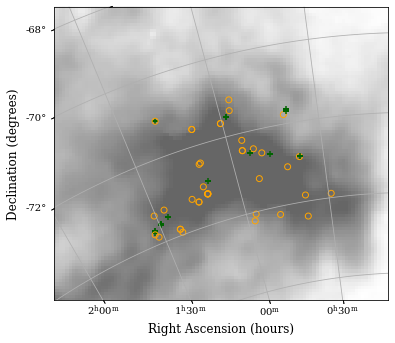

In [11]:
mom0_file = 'hi_zea_ms_mom0.fits'
plot_source_loc_map(j19_table, 'figures', False, background=mom0_file, name='source_loc_atca', field_centre=field_centre)


### G340 Field Source Plot


Plotting 348 source locations over background of ../gaskap-abs/hi_zea_all_mom0.fits.
247.310542 256.952472 -47.970827 -42.053603
<SkyCoord (FK4: equinox=B1950.000, obstime=B1950.000): (ra, dec) in deg
    (252.131507, -45.012215)>
  Output figures/source_loc_g340.png


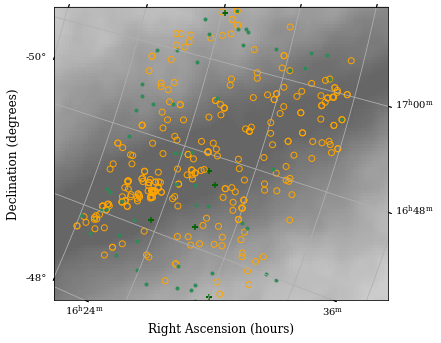

In [12]:
spectra_table = parse_single_table('../gaskap-abs/sb13536/askap_spectra.vot').to_table()
mom0_file = '../gaskap-abs/hi_zea_all_mom0.fits'
field_centre = plot_source_loc_map(spectra_table, 'figures', True, background=mom0_file, name='source_loc_g340')


## SMC source noise plot

Fig 3: Distribution of continuum sources showing their optical depth noise against the SMC HI column density map from GASKAP (Pingel et al., 2021). Triangles are sources excluded due to either high noise or being on the edges of the cube, squares are sources against which absorption was detected, and circles are other sources. Darker colours indicate lower optical depth noise.

In [5]:

    
    
def plot_source_noise_map(spectra_table, figures_folder, is_mw, trimmed, background='hi_zea_ms_mom0.fits', name='source_loc',
                       field_centre=None):

    print('\nPlotting {} source locations over background of {}.'.format(len(spectra_table), background))

    #fig = plt.figure(figsize=(7.2, 5.4))
    #fig = plt.figure(figsize=(8, 6))
    fig = plt.figure(figsize=(12, 9))


    ax, wcs = plot_background_map(fig, background, lon_tick_labels='b', fontsize=16)

    #plt.colorbar(im,fraction=0.046, pad=0.04)
    x = np.asarray(spectra_table['ra'])
    y = np.asarray(spectra_table['dec'])
    #colors = np.log10(np.asarray(spectra_table['sd_cont'])*100)
    c = np.asarray(spectra_table['sd_cont'])*100
    #norm=colors.LogNorm(vmin=np.min(c), vmax=np.max(c))
    norm=colors.LogNorm(vmin=0.1, vmax=100)
    m = np.full(x.shape, 'o')
    det = spectra_table['has_other_abs']


    print (x.shape, y.shape, c.shape, m.shape)
    sc = ax.scatter(x[trimmed], y[trimmed], transform=ax.get_transform('world'), cmap='plasma',
               marker='v', edgecolor=None, c=c[trimmed], alpha=0.65, norm=norm, zorder=2, s=70)
    sc = ax.scatter(x[~det & ~trimmed], y[~det & ~trimmed], transform=ax.get_transform('world'), cmap='plasma',
               marker='o', edgecolor='white', c=c[~det & ~trimmed], alpha=0.65, norm=norm, zorder=2, s=90)
    sc = ax.scatter(x[det & ~trimmed], y[det & ~trimmed], transform=ax.get_transform('world'), cmap='plasma',
               marker='s', edgecolor='black', c=c[det & ~trimmed], alpha=0.7, norm=norm, zorder=3, s=110)

    #add_sources(ax, spectra_table, 3, 5, is_mw)
    cbar = fig.colorbar(sc)
    cbar.set_label("Optical Depth Noise (percent)", fontsize=12)#, loc='right')
    cbar.set_alpha(1)
    cbar.draw_all()

    prefix = figures_folder + "/" + name
    print ("  Output", prefix+".png")
    fig.savefig(prefix + ".png", bbox_inches='tight')
    fig.savefig(prefix + ".pdf", bbox_inches='tight')
    return field_centre




Plotting 373 source locations over background of SMC_askap_parkes_PBC_pilot_K_mom0.fits.


/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


(373,) (373,) (373,) (373,)
  Output figures/source_noise_smc.png


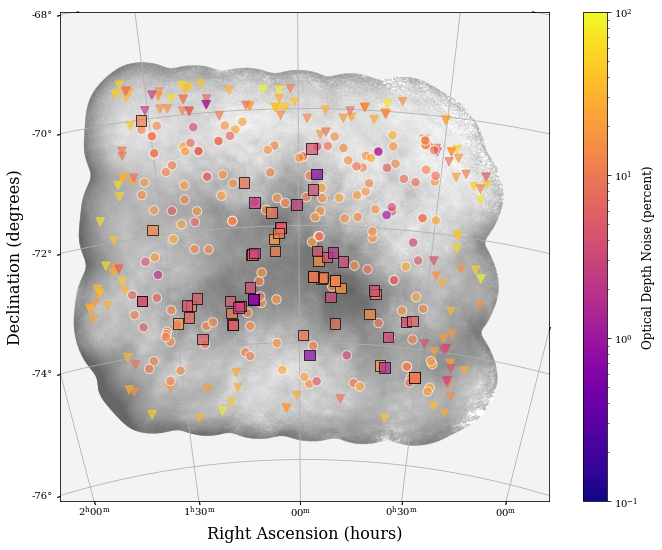

In [6]:
spectra_table = parse_single_table('sb10944/v3a/askap_spectra.vot').to_table()
trimmed_spectra_table = parse_single_table('gaskap_smc_spectra.vot').to_table()
trimmed = ~np.isin(spectra_table['comp_name'], trimmed_spectra_table['comp_name'])
mom0_file = 'SMC_askap_parkes_PBC_pilot_K_mom0.fits'
field_centre = plot_source_noise_map(spectra_table, 'figures', False, trimmed, background=mom0_file, name='source_noise_smc')



In [ ]:
np.asarray(spectra_table['sd_cont'])*100

## Spin temperature distribution plot

Figure 11. (Bottom) Distribution of the mean spin temperatures against the SMC HI column density map from GASKAP (Pingel et al., 2021).

In [92]:

    
    
def plot_spin_temp_map(spectra_table, is_wing, is_bar, figures_folder, is_mw, background='hi_zea_ms_mom0.fits', name='spin_temp',
                       field_centre=None):

    print('\nPlotting {} feature locations over background of {}.'.format(len(spectra_table), background))

    #fig = plt.figure(figsize=(7.2, 5.4))
    #fig = plt.figure(figsize=(8, 6))
    fig = plt.figure(figsize=(13, 8))


    ax, wcs = plot_background_map(fig, background, lon_tick_labels='b', fontsize=16)

    #plt.colorbar(im,fraction=0.046, pad=0.04)
    x = np.asarray(spectra_table['ra'])
    y = np.asarray(spectra_table['dec'])
    #colors = np.log10(np.asarray(spectra_table['sd_cont'])*100)
    c = np.asarray(spectra_table['mean_ts'])
    #norm=colors.LogNorm(vmin=np.min(c), vmax=np.max(c))
    norm=colors.LogNorm(vmin=50, vmax=2000)
    m = np.full(x.shape, 'o')
    det = spectra_table['has_other_abs'] & (spectra_table['mean_ts'] > 0)
    is_other = ~is_wing & ~is_bar
    cmap = 'inferno' # cmr.gem 
    #zorder=spectra_table['mean_ts']
    alpha = 0.7
    size=180


    print (x.shape, y.shape, c.shape, m.shape)
    #sc = ax.scatter(x[trimmed], y[trimmed], transform=ax.get_transform('world'), cmap='plasma',
    #           marker='v', edgecolor=None, c=c[trimmed], alpha=0.65, norm=norm, zorder=2, s=70)
    #sc = ax.scatter(x[~det & ~trimmed], y[~det & ~trimmed], transform=ax.get_transform('world'), cmap='plasma',
    #           marker='o', edgecolor='white', c=c[~det & ~trimmed], alpha=0.65, norm=norm, zorder=2, s=90)
    sc = ax.scatter(x[det & is_bar], y[det & is_bar], transform=ax.get_transform('world'), cmap=cmap,
               marker='^', edgecolor='black', c=c[det & is_bar], alpha=alpha, norm=norm, zorder=3, s=size, label=r'Bar Detections')
    sc = ax.scatter(x[det & is_wing], y[det & is_wing], transform=ax.get_transform('world'), cmap=cmap,
               marker='v', edgecolor='black', c=c[det & is_wing], alpha=alpha, norm=norm, zorder=3, s=size, label=r'Wing Detections')
    sc = ax.scatter(x[det & is_other], y[det & is_other], transform=ax.get_transform('world'), cmap=cmap,
               marker='*', edgecolor='black', c=c[det & is_other], alpha=alpha, norm=norm, zorder=3, s=size, label=r'Other Detections')

    ax.legend(loc='upper left')

    #add_sources(ax, spectra_table, 3, 5, is_mw)
    cbar = fig.colorbar(sc,location='left')
    cbar.set_ticks([100,500,1000])
    #cbar.set_ticklabels(["100 K / 30%","500 K / 6 %","1000 / 3 %"])
    #cbar.set_label("Mean Spin Temperature (K) / Cold Gas Fraction (%)", fontsize=12)#, loc='right')
    cbar.set_ticklabels(["100","500","1000"])
    cbar.set_label("Mean Spin Temperature (K)", fontsize=12)#, loc='right')
    #cbar.set_alpha(1)
    #cbar.draw_all()
    cbar.solids.set(alpha=1)
    cbar2 = fig.colorbar(sc)
    cbar2.set_ticks([100,500,1000])
    cbar2.set_ticklabels(["30","6","3"])
    
    cbar2.set_label("Cold Gas Fraction (%)", fontsize=12)#, loc='right')
    cbar2.ax.invert_yaxis()
    #cbar2.set_alpha(1)
    #cbar.set_alpha(1)
    cbar2.solids.set(alpha=1)
    cbar.solids.set(alpha=1)
    #cbar2.draw_all()


    prefix = figures_folder + "/" + name
    print ("  Output", prefix+".png")
    fig.savefig(prefix + ".png", bbox_inches='tight')
    fig.savefig(prefix + ".pdf", bbox_inches='tight')
    return field_centre




        Use `regions.Regions.read` instead. [warnings]



Plotting 229 feature locations over background of SMC_askap_parkes_PBC_pilot_K_mom0.fits.


/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


(229,) (229,) (229,) (229,)
  Output figures/spin_temp_smc.png


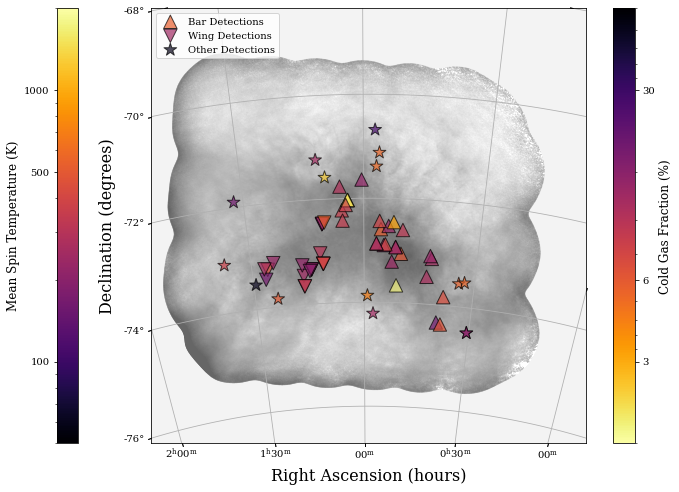

In [93]:
spectra_table = parse_single_table('gaskap_smc_spectra.vot').to_table()
mom0_file = 'SMC_askap_parkes_PBC_pilot_K_mom0.fits'


smc_filter = spectra_table['nh_gass'] >= 2E21

smc_reg = regions.ds9.read.read_ds9('smc-regions-adj2.reg')
bar = smc_reg[0]
wing = smc_reg[1]

header = fits.getheader(mom0_file)
w = WCS(header)

p = SkyCoord(spectra_table['ra'], spectra_table['dec'], frame='fk5')
is_wing = wing.contains(p, w) & smc_filter
is_bar = bar.contains(p, w) & smc_filter

field_centre = plot_spin_temp_map(spectra_table, is_wing, is_bar, 'figures', False, background=mom0_file, name='spin_temp_smc')




In [44]:
import matplotlib as mpl

print(mpl.__version__)

3.4.3
